# Setting y-axis limits
This example shows how to intelligently set y-axis limits when we are trying to hightlight sites of selection and some of the samples are mostly "noise."

First, import `dmslogo` along with the other necessary packages:

In [1]:
import numpy

import pandas as pd

import dmslogo
import dmslogo.utils

Read in some real immune selection data for influenza HA:

In [2]:
ha_df = pd.read_csv("input_files/HA_serum_diffsel.csv")

ha_df.head()

,sample,isite,site,wildtype,mutation,mutdiffsel,positive_diffsel,negative_diffsel
0,age 2.2,0,-16,M,A,-1.525,0.0,-16.841
1,age 2.2,0,-16,M,C,-1.040,0.0,-16.841
2,age 2.2,0,-16,M,D,-1.675,0.0,-16.841
3,age 2.2,0,-16,M,E,-1.050,0.0,-16.841
4,age 2.2,0,-16,M,F,-0.833,0.0,-16.841


Add a site label that gives both the site number and wildtype identity, and also indicate which sites to show in the logo plots:

In [3]:
sites_to_show = [
    "157",
    "158",
    "159",
    "160",
    "188",
    "189",
    "190",
    "192",
    "193",
    "194",
    "221",
    "222",
    "223",
]

ha_df = ha_df.assign(
    site_label=lambda x: x["wildtype"] + x["site"],
    to_show=lambda x: x["site"].isin(sites_to_show),
)

Now use [dmslogo.facet.facet_plot](https://jbloomlab.github.io/dmslogo/dmslogo.facet.html#dmslogo.facet.facet_plot) to facet line and logo plots for the samples, using `clip_negative_heights` to only show the positive values.
Here we just use the "default" setting for the y-axis limits, which gives a reasonable looking plot:

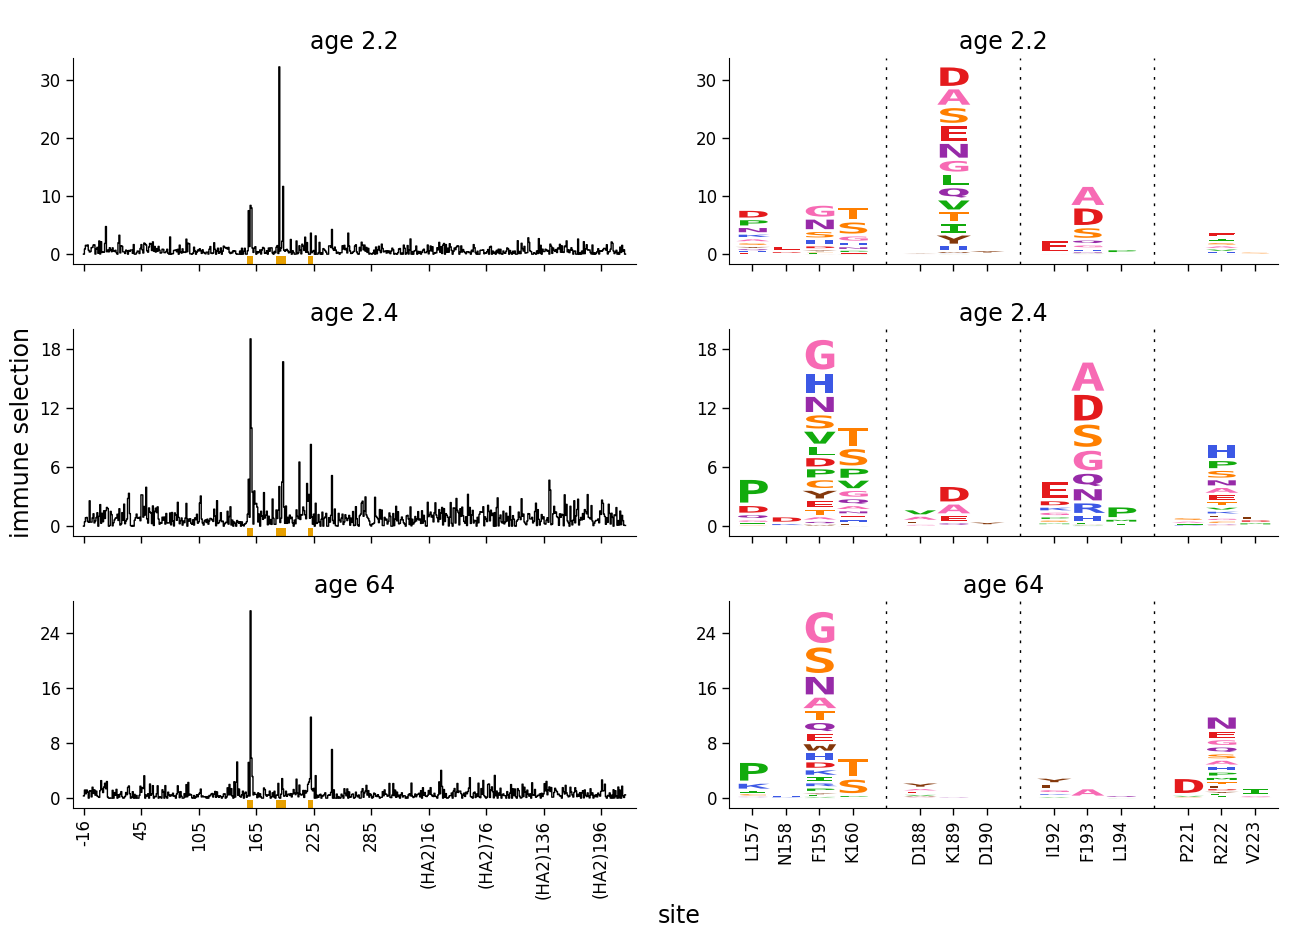

In [4]:
# NBVAL_IGNORE_OUTPUT

fig, axes = dmslogo.facet_plot(
    ha_df,
    gridrow_col="sample",
    x_col="isite",
    show_col="to_show",
    draw_line_kwargs={
        "height_col": "positive_diffsel",
        "xtick_col": "site",
        "ylabel": "immune selection",
    },
    draw_logo_kwargs={
        "letter_col": "mutation",
        "letter_height_col": "mutdiffsel",
        "xtick_col": "site_label",
        "xlabel": "site",
        "ylabel": "immune selection",
        "clip_negative_heights": True,
    },
    share_ylabel=True,
    share_xlabel=True,
    share_ylim_across_rows=False,
)

But now let's add a sample where all the selection is just "noise", as is the case if there really isn't any selection at a site.
We create and add this noisy sample by just randomly modifying the selection values for one of the real samples:

In [5]:
numpy.random.seed(1)  # seed for reproducible output

noise_sample = (
    ha_df.query('sample == "age 64"')
    .assign(
        sample="noisy sample",
        mutdiffsel=lambda x: numpy.random.normal(
            loc=0, scale=0.1, size=x["mutdiffsel"].shape
        ),
        positive_mutdiffsel=lambda x: x["mutdiffsel"].clip(lower=0),
        negative_mutdiffsel=lambda x: x["mutdiffsel"].clip(upper=0),
        positive_diffsel=lambda x: x.groupby("site")["positive_mutdiffsel"].transform(
            "sum"
        ),
        negative_diffsel=lambda x: x.groupby("site")["negative_mutdiffsel"].transform(
            "sum"
        ),
    )
    .drop(columns=["positive_mutdiffsel", "negative_mutdiffsel"])
)

noise_df = pd.concat([ha_df, noise_sample], ignore_index=True)

Now plot the data including that noisy sample:

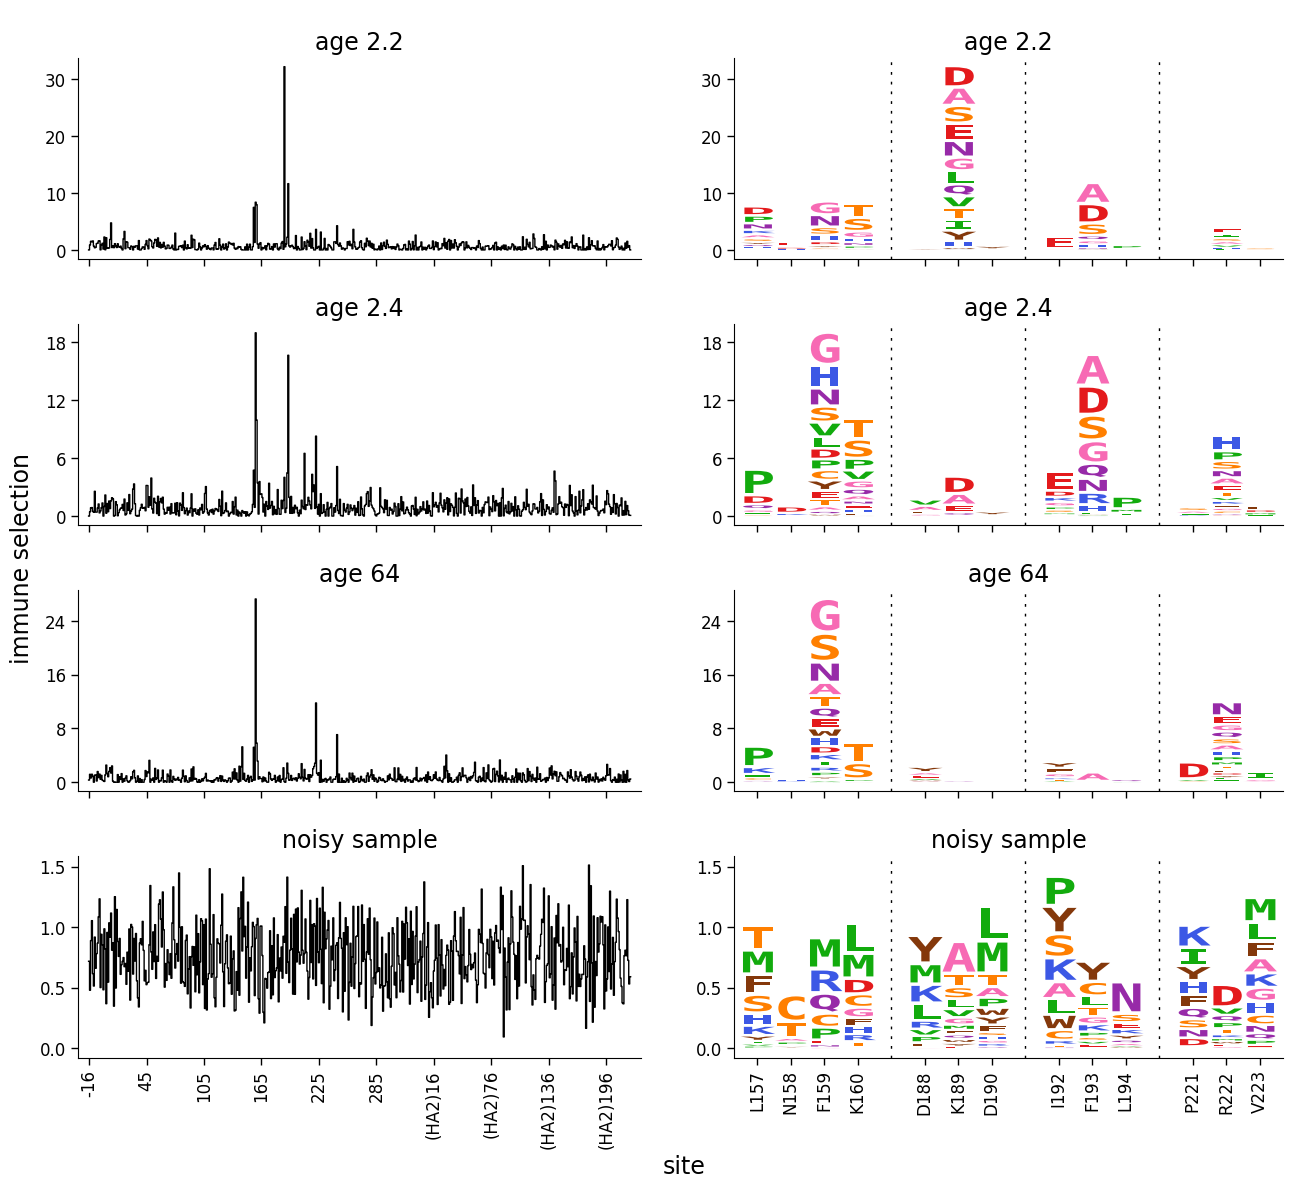

In [6]:
# NBVAL_IGNORE_OUTPUT

fig, axes = dmslogo.facet_plot(
    noise_df,
    gridrow_col="sample",
    x_col="isite",
    show_col="to_show",
    draw_line_kwargs={
        "height_col": "positive_diffsel",
        "xtick_col": "site",
        "ylabel": "immune selection",
        "show_color": None,
    },
    draw_logo_kwargs={
        "letter_col": "mutation",
        "letter_height_col": "mutdiffsel",
        "xtick_col": "site_label",
        "xlabel": "site",
        "ylabel": "immune selection",
        "clip_negative_heights": True,
    },
    share_ylabel=True,
    share_xlabel=True,
    share_ylim_across_rows=False,
)

The above plot doesn't look good.
The reason is that it makes sense to scale the upper y-axis limit to the maximum data value when there are truly a few sites of strong selection.
But when everything is actually noise, we want all the values to be low, and not to scale the y-axis limit to the maximum data value.

This can be done using a [dmslogo.utils.AxLimSetter](https://jbloomlab.github.io/dmslogo/dmslogo.utils.html#dmslogo.utils.AxLimSetter).
The docs linked to for that class explains exactly how it works, but the idea is as follows: this class enables us to make the limits for noisy data much higher than any of the data points.
The approach is premised on the idea that if there is real selection, a few sites should have much greater signal than all other sites. To do this, the setters enable us to specify that the axis limit should be set such that some quantile of the data is at some fraction of the axis height.
For instance, a reasonable approach is to set the y-axis such that the 50th percentile (0.5 quantile) of the site-level selection is at 5% (0.05 fraction) of the total data height **or** to the maximum of the data, whichever is larger.
This means for noisy samples where no values are much greater than the 50th percentile, the axis limit will be far above the data.
Here we create such a setter, and then use it to set the limits on the line plot (which is the plot that contains all sites):

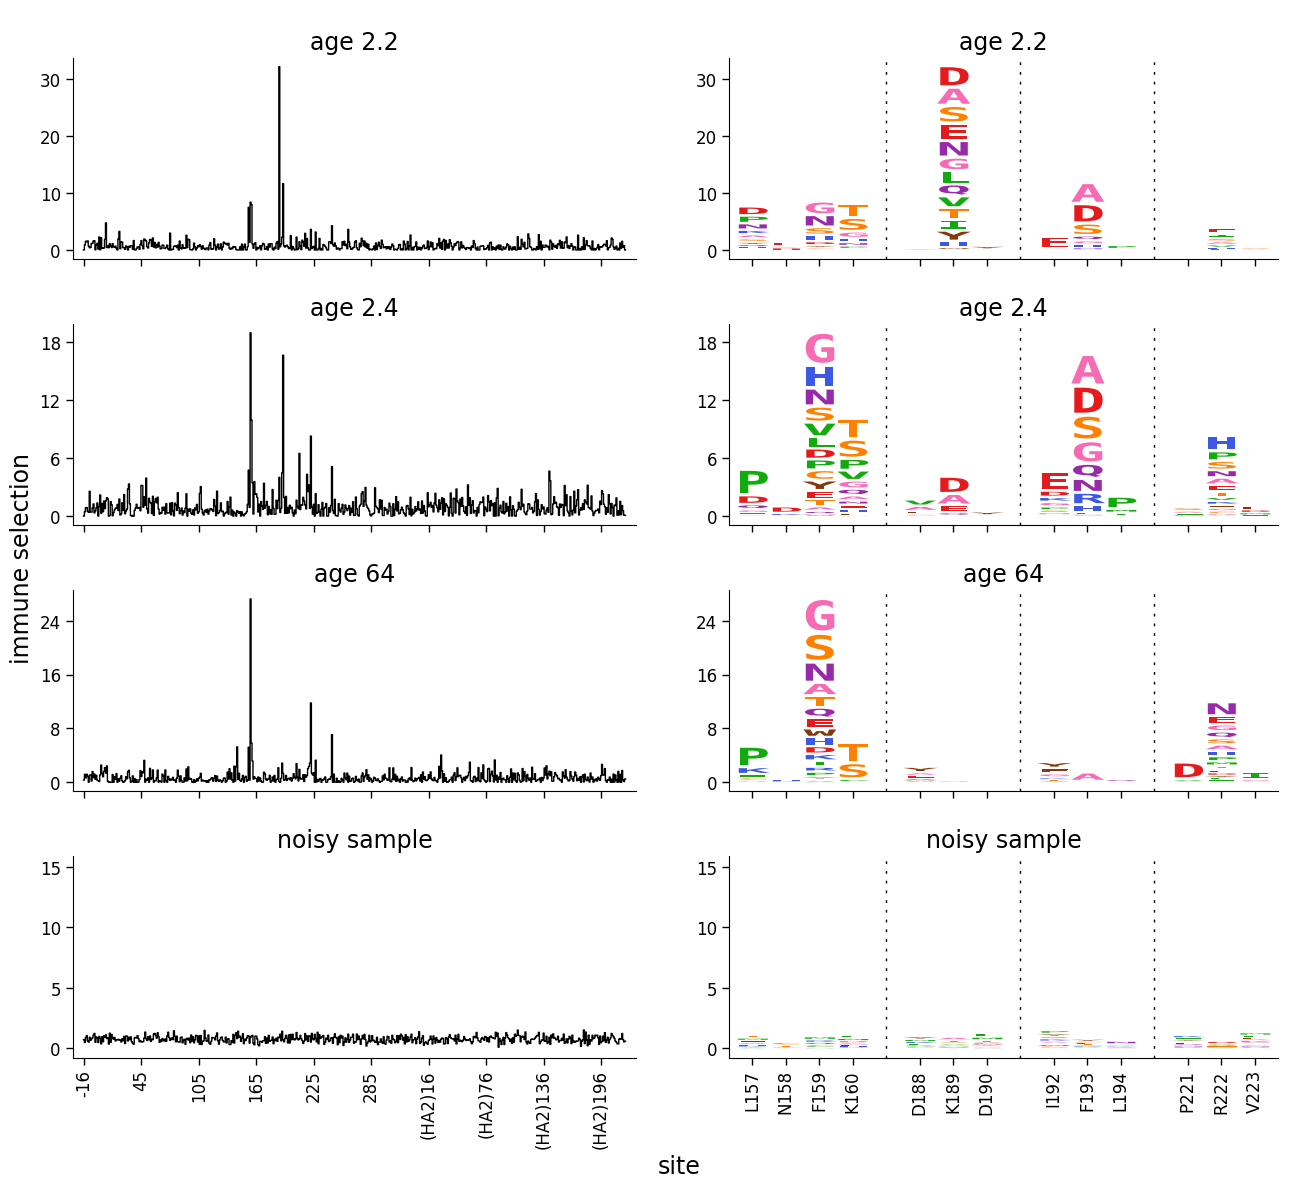

In [7]:
# NBVAL_IGNORE_OUTPUT

ylim_setter = dmslogo.utils.AxLimSetter(max_from_quantile=(0.5, 0.05))

fig, axes = dmslogo.facet_plot(
    noise_df,
    gridrow_col="sample",
    x_col="isite",
    show_col="to_show",
    draw_line_kwargs={
        "height_col": "positive_diffsel",
        "xtick_col": "site",
        "ylabel": "immune selection",
        "ylim_setter": ylim_setter,
        "show_color": None,
    },
    draw_logo_kwargs={
        "letter_col": "mutation",
        "letter_height_col": "mutdiffsel",
        "xtick_col": "site_label",
        "xlabel": "site",
        "ylabel": "immune selection",
        "clip_negative_heights": True,
    },
    share_ylabel=True,
    share_xlabel=True,
    share_ylim_across_rows=False,
)

The plot above looks much better.
The axis limits for the three samples with "real" selection aren't changed at all because there are actually a few sites of strong selection that greatly exceed the selection at the 50th percentile site.
But for the noisy sample, since all of the selection is around the 50th percentile, the axis limit is much above the data.

If we are **only** showing logo plots, then setting the limits using the above method won't work if the logo plots have already been subset to just the values of greatest interest.
Rather, we want to compute the limits using the setter on **all** the data (see [dmslogo.utils.AxLimSetter](https://jbloomlab.github.io/dmslogo/dmslogo.utils.html#dmslogo.utils.AxLimSetter) for how to do this), and then pass those limits to the creation of the logo plots.
So here is how we would do this if faceting logo plots:

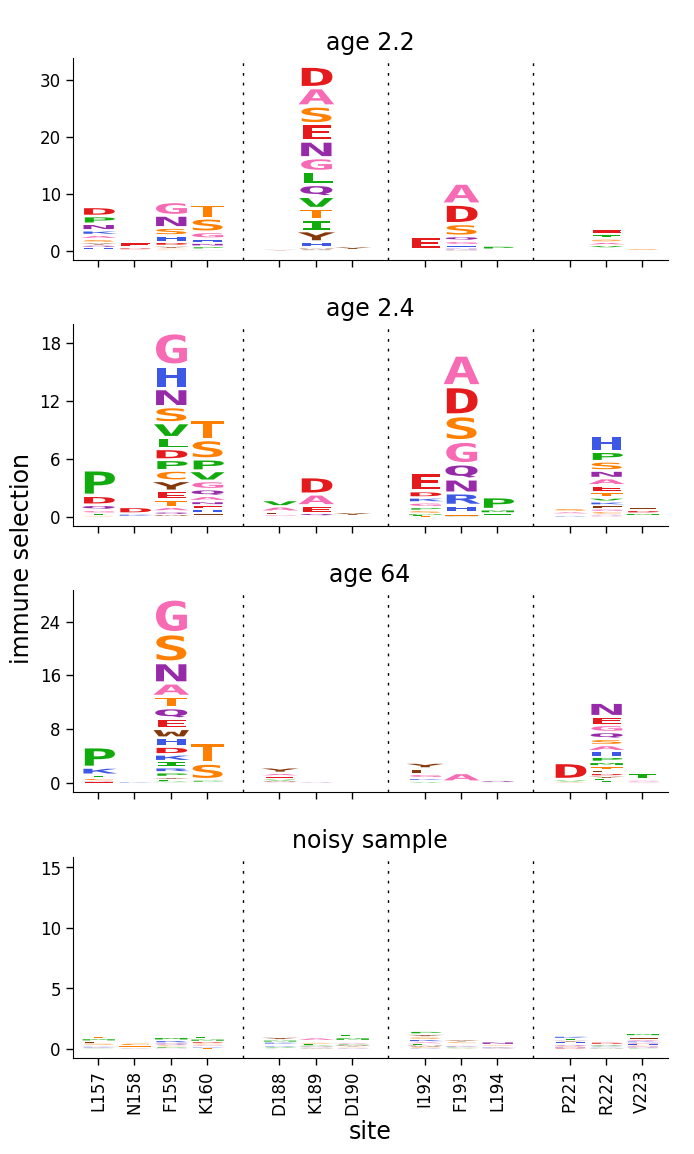

In [8]:
# NBVAL_IGNORE_OUTPUT

# get y-limits for each sample using `ylim_setter` on the positive site diffsel
ylims = {}
for sample, sample_df in noise_df.groupby("sample"):
    site_diffsel = sample_df[["site", "positive_diffsel"]].drop_duplicates()[
        "positive_diffsel"
    ]
    ylims[sample] = ylim_setter.get_lims(site_diffsel)

# now make facet plot passing the ylimits via `set_ylims`
fig, axes = dmslogo.facet_plot(
    noise_df,
    gridrow_col="sample",
    x_col="isite",
    show_col="to_show",
    draw_logo_kwargs={
        "letter_col": "mutation",
        "letter_height_col": "mutdiffsel",
        "xtick_col": "site_label",
        "xlabel": "site",
        "ylabel": "immune selection",
        "clip_negative_heights": True,
    },
    share_ylabel=True,
    share_xlabel=True,
    share_ylim_across_rows=False,
    set_ylims=ylims,
)